In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 160
BATCH_SIZE = 4
CHANNELS = 3
EPOCHS = 50

In [3]:
import zipfile
zip_path = "/content/archive.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [5]:
class_names = dataset.class_names
n_classes = len(class_names)

In [6]:
len(dataset)

5160

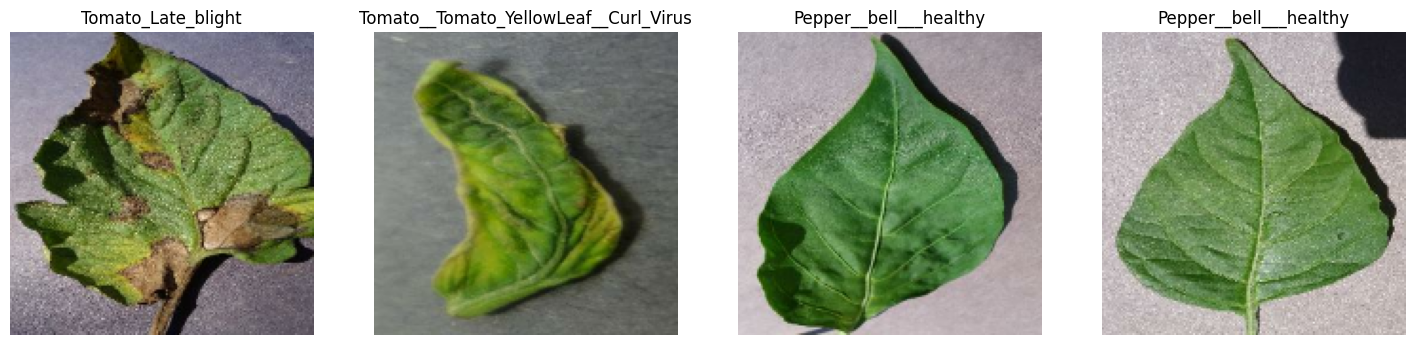

In [7]:
plt.figure(figsize=(18, 18))
for image_batch, label_batch in dataset.take(1):
  for i in range(4):
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

4128.0

In [9]:
train_ds= dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

5106

In [11]:
val_size=0.1
len(dataset)*val_size

516.0

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

5100

In [14]:
train_split=0.8
val_split=0.1
test_split=0.1
assert train_split + val_split + test_split == 1

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

4128

In [18]:
len(val_ds)

516

In [19]:
len(test_ds)

516

In [21]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [22]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(160, 160),
    tf.keras.layers.Rescaling(1./255)
])


In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])


In [24]:
train_ds = train_ds.map(
lambda x,y : (data_augmentation(x, training=True), y)).prefetch(buffer_size = tf.data.AUTOTUNE)


In [25]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(160, 160, 3)),
    resize_and_rescale,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])



In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [29]:
History = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 132s 25ms/step - accuracy: 0.6465 - loss: 1.1293 - val_accuracy: 0.8261 - val_loss: 0.5188
Epoch 2/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - accuracy: 0.7982 - loss: 0.6097 - val_accuracy: 0.8299 - val_loss: 0.4759
Epoch 3/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 114s 25ms/step - accuracy: 0.8115 - loss: 0.5498 - val_accuracy: 0.8477 - val_loss: 0.4490
Epoch 4/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.8271 - loss: 0.5145 - val_accuracy: 0.8716 - val_loss: 0.3936
Epoch 5/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - accuracy: 0.8341 - loss: 0.5005 - val_accuracy: 0.8702 - val_loss: 0.3768
Epoch 6/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 114s 25ms/step - accuracy: 0.8398 - loss: 0.4753 - val_accuracy: 0.8356 - val_loss: 0.4593
Epoch 7/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 113s 24ms/step - accuracy: 0.8486 - loss: 0.4709 - val_accuracy: 0.8697 - val_loss: 0.3916
Epoch 8/50
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - accuracy: 

In [30]:
scores = model.evaluate(test_ds)

516/516 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9050 - loss: 0.2939


In [31]:
scores

[0.27008938789367676, 0.9064922332763672]

In [32]:
History

In [33]:
History.params

{'verbose': 1, 'epochs': 50, 'steps': 4128}

In [34]:
History.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
type(History.history['loss'])

list

In [36]:
len(History.history['loss'])

50

In [37]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

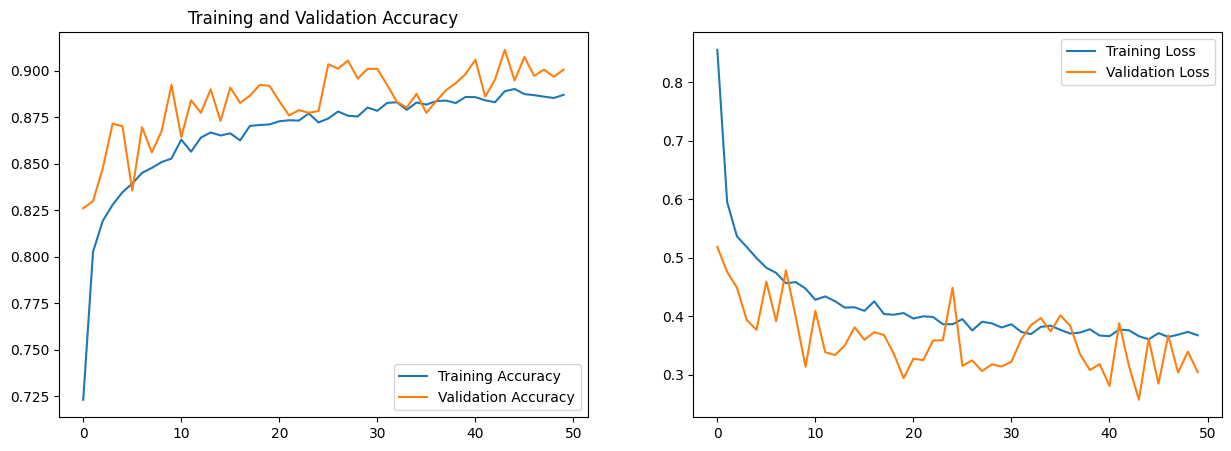

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [40]:
np.argmax([3.8334638e-05, 9.9991924e-01, 4.2371310e-05])

np.int64(1)

first image to predict
actual label: Tomato_Leaf_Mold
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Tomato_Leaf_Mold


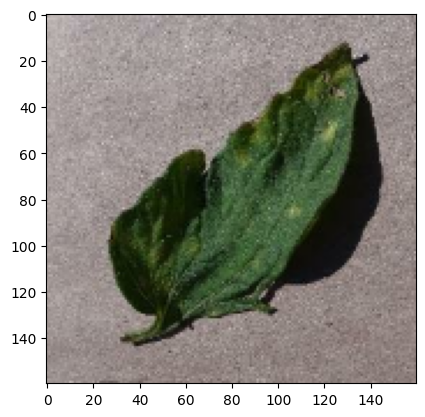

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [41]:
def predict(model, img):
  img_array = tf.image.resize(images_batch[0], (160, 160))
  img_array = tf.expand_dims(img_array, axis=0)
  img_array = tf.cast(img_array, tf.float32) / 255.0


  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


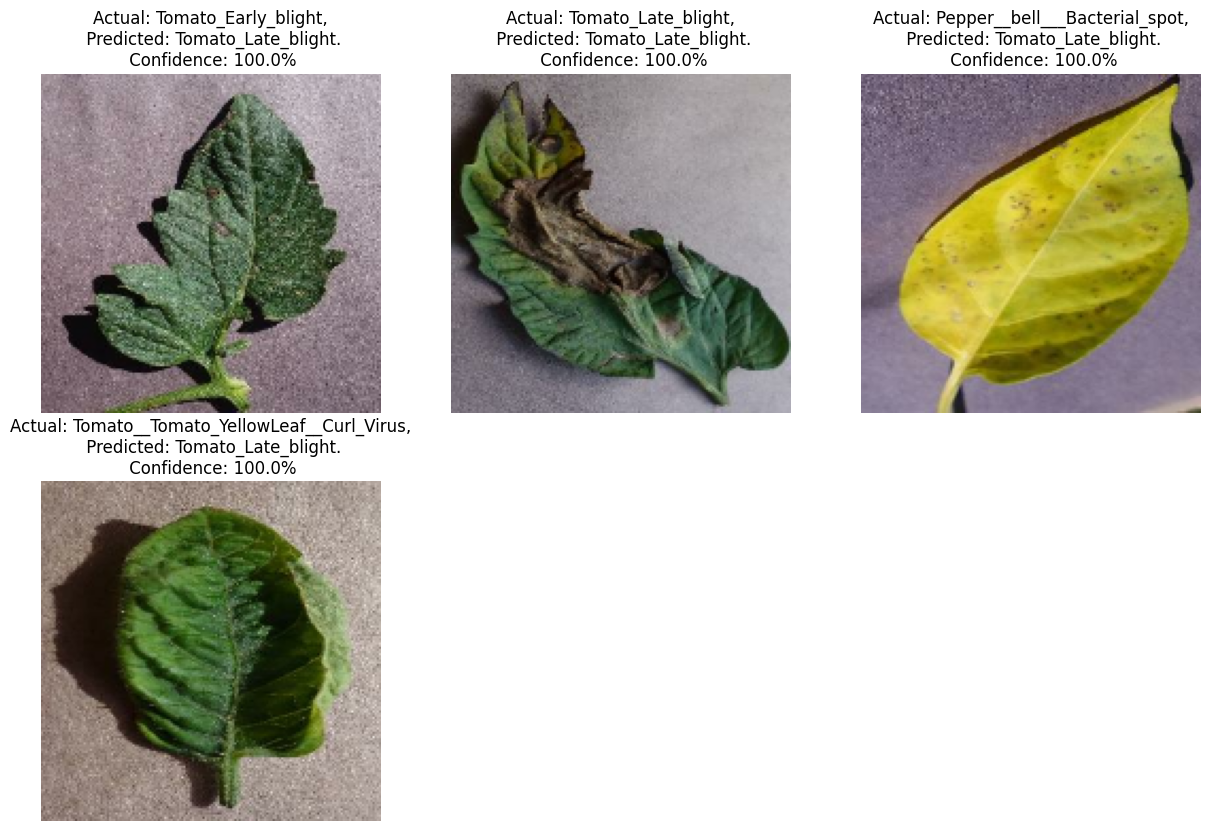

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [43]:
model_version=1
model.save("plant_model.keras")

In [44]:
!zip -r plant_model.zip plant_model.keras

  adding: plant_model.keras (deflated 15%)


In [45]:
from google.colab import files
files.download("plant_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
import pickle

with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)



In [48]:
from google.colab import files
files.download("class_names.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>